In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalMaxPool1D()(output) for output in layer_outputs[-2:]])
    x = BatchNormalization()(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 32)    128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 32)    0           batch_normalization_v1[0][0]     
_____________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 32)    192         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_9 (Batch (None, 16000, 32)    128         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 32)    0           batch_normalization_v1_9[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 32)    192         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_22 (Batc (None, 16000, 32)    128         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_22[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.4523 - acc: 0.2255
Epoch 00001: val_loss improved from inf to 2.51541, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_3_conv_checkpoint/001-2.5154.hdf5
36805/36805 [==============================] - 31s 842us/sample - loss: 2.4516 - acc: 0.2259 - val_loss: 2.5154 - val_acc: 0.1819
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9689 - acc: 0.3566
Epoch 00002: val_loss improved from 2.51541 to 1.82753, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_3_conv_checkpoint/002-1.8275.hdf5
36805/36805 [==============================] - 28s 752us/sample - loss: 1.9689 - acc: 0.3566 - val_loss: 1.8275 - val_acc: 0.3965
Epoch 3/500
36736/36805 [============================>.] - ET

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7429 - acc: 0.7689
Epoch 00022: val_loss improved from 0.76263 to 0.72265, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_3_conv_checkpoint/022-0.7226.hdf5
36805/36805 [==============================] - 28s 747us/sample - loss: 0.7429 - acc: 0.7689 - val_loss: 0.7226 - val_acc: 0.7827
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7295 - acc: 0.7720
Epoch 00023: val_loss did not improve from 0.72265
36805/36805 [==============================] - 28s 749us/sample - loss: 0.7296 - acc: 0.7720 - val_loss: 0.7243 - val_acc: 0.7754
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7220 - acc: 0.7736
Epoch 00024: val_loss improved from 0.72265 to 0.69664, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_3_conv_checkpoint/024-0.6966.hdf5
36805/36805 [==============================] - 27s 746us/sample - loss: 0.7221 - a

Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5713 - acc: 0.8224
Epoch 00048: val_loss improved from 0.62258 to 0.59755, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_3_conv_checkpoint/048-0.5976.hdf5
36805/36805 [==============================] - 28s 752us/sample - loss: 0.5713 - acc: 0.8224 - val_loss: 0.5976 - val_acc: 0.8174
Epoch 49/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5655 - acc: 0.8245
Epoch 00049: val_loss did not improve from 0.59755
36805/36805 [==============================] - 28s 747us/sample - loss: 0.5655 - acc: 0.8245 - val_loss: 0.6117 - val_acc: 0.8141
Epoch 50/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5596 - acc: 0.8237
Epoch 00050: val_loss did not improve from 0.59755
36805/36805 [==============================] - 28s 747us/sample - loss: 0.5595 - acc: 0.8236 - val_loss: 0.7004 - val_acc: 0.7843
Epoch 51/500
36800/36805 [============================>.] -

36736/36805 [============================>.] - ETA: 0s - loss: 0.4883 - acc: 0.8463
Epoch 00075: val_loss did not improve from 0.56015
36805/36805 [==============================] - 27s 746us/sample - loss: 0.4882 - acc: 0.8463 - val_loss: 0.6056 - val_acc: 0.8160
Epoch 76/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4909 - acc: 0.8463
Epoch 00076: val_loss did not improve from 0.56015
36805/36805 [==============================] - 27s 743us/sample - loss: 0.4908 - acc: 0.8463 - val_loss: 0.5846 - val_acc: 0.8216
Epoch 77/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4877 - acc: 0.8469
Epoch 00077: val_loss did not improve from 0.56015
36805/36805 [==============================] - 27s 746us/sample - loss: 0.4877 - acc: 0.8469 - val_loss: 0.5744 - val_acc: 0.8239
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4837 - acc: 0.8473
Epoch 00078: val_loss did not improve from 0.56015
36805/36805 [==================

36736/36805 [============================>.] - ETA: 0s - loss: 0.4355 - acc: 0.8625
Epoch 00104: val_loss did not improve from 0.54995
36805/36805 [==============================] - 27s 746us/sample - loss: 0.4356 - acc: 0.8625 - val_loss: 0.5932 - val_acc: 0.8188
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4362 - acc: 0.8614
Epoch 00105: val_loss did not improve from 0.54995
36805/36805 [==============================] - 27s 741us/sample - loss: 0.4363 - acc: 0.8614 - val_loss: 0.5597 - val_acc: 0.8290
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4350 - acc: 0.8618
Epoch 00106: val_loss did not improve from 0.54995
36805/36805 [==============================] - 27s 746us/sample - loss: 0.4350 - acc: 0.8618 - val_loss: 0.6336 - val_acc: 0.8064
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4312 - acc: 0.8614
Epoch 00107: val_loss did not improve from 0.54995
36805/36805 [===============

36736/36805 [============================>.] - ETA: 0s - loss: 0.3998 - acc: 0.8716
Epoch 00133: val_loss did not improve from 0.54641
36805/36805 [==============================] - 28s 749us/sample - loss: 0.3997 - acc: 0.8716 - val_loss: 0.5817 - val_acc: 0.8304
Epoch 134/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3981 - acc: 0.8734
Epoch 00134: val_loss did not improve from 0.54641
36805/36805 [==============================] - 28s 748us/sample - loss: 0.3985 - acc: 0.8734 - val_loss: 0.5849 - val_acc: 0.8293
Epoch 135/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3955 - acc: 0.8739
Epoch 00135: val_loss did not improve from 0.54641
36805/36805 [==============================] - 27s 745us/sample - loss: 0.3959 - acc: 0.8738 - val_loss: 0.6422 - val_acc: 0.8113
Epoch 136/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3969 - acc: 0.8733
Epoch 00136: val_loss did not improve from 0.54641
36805/36805 [===============

Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3714 - acc: 0.8791
Epoch 00163: val_loss did not improve from 0.54641
36805/36805 [==============================] - 27s 745us/sample - loss: 0.3715 - acc: 0.8791 - val_loss: 0.6223 - val_acc: 0.8146
Epoch 164/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3728 - acc: 0.8809
Epoch 00164: val_loss did not improve from 0.54641
36805/36805 [==============================] - 27s 745us/sample - loss: 0.3731 - acc: 0.8808 - val_loss: 0.5701 - val_acc: 0.8372
Epoch 165/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3680 - acc: 0.8836
Epoch 00165: val_loss did not improve from 0.54641
36805/36805 [==============================] - 27s 746us/sample - loss: 0.3683 - acc: 0.8834 - val_loss: 0.5574 - val_acc: 0.8388
Epoch 166/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3694 - acc: 0.8827
Epoch 00166: val_loss did not improve from 0.54641
36805/36805 [=

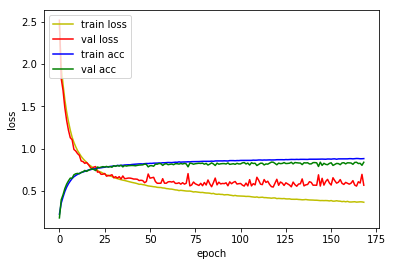

4815/4815 [==============================] - 2s 363us/sample - loss: 0.6524 - acc: 0.8077
Loss: 0.6523727787679848 Accuracy: 0.8076843

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.2901 - acc: 0.2738
Epoch 00001: val_loss improved from inf to 2.15835, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_4_conv_checkpoint/001-2.1584.hdf5
36805/36805 [==============================] - 32s 860us/sample - loss: 2.2896 - acc: 0.2739 - val_loss: 2.1584 - val_acc: 0.3103
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7333 - acc: 0.4429
Epoch 00002: val_loss improved from 2.15835 to 1.58225, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_4_conv_checkpoint/002-1.5822.hdf5
36805/36805 [==============================] - 29s 779us/sample - loss: 1.7332 - acc: 0.4430 - val_loss: 1.5822 - val_acc: 0.5029
Epoch 3/500
36736/36805 [==========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.4838 - acc: 0.8546
Epoch 00023: val_loss did not improve from 0.51527
36805/36805 [==============================] - 28s 773us/sample - loss: 0.4838 - acc: 0.8545 - val_loss: 0.5201 - val_acc: 0.8421
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4720 - acc: 0.8574
Epoch 00024: val_loss improved from 0.51527 to 0.49112, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_4_conv_checkpoint/024-0.4911.hdf5
36805/36805 [==============================] - 29s 775us/sample - loss: 0.4720 - acc: 0.8573 - val_loss: 0.4911 - val_acc: 0.8502
Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4620 - acc: 0.8610
Epoch 00025: val_loss improved from 0.49112 to 0.48933, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_4_conv_checkpoint/025-0.4893.hdf5
36805/36805 [==============================] - 29s 776us/sample - loss: 0.4621 - acc: 0.8609 - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.3268 - acc: 0.8997
Epoch 00049: val_loss did not improve from 0.41838
36805/36805 [==============================] - 28s 773us/sample - loss: 0.3268 - acc: 0.8997 - val_loss: 0.4374 - val_acc: 0.8619
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3268 - acc: 0.8993
Epoch 00050: val_loss did not improve from 0.41838
36805/36805 [==============================] - 28s 770us/sample - loss: 0.3268 - acc: 0.8993 - val_loss: 0.4441 - val_acc: 0.8626
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3221 - acc: 0.8995
Epoch 00051: val_loss did not improve from 0.41838
36805/36805 [==============================] - 28s 769us/sample - loss: 0.3220 - acc: 0.8995 - val_loss: 0.4253 - val_acc: 0.8637
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3181 - acc: 0.9036
Epoch 00052: val_loss did not improve from 0.41838
36805/36805 [==================

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2460 - acc: 0.9230
Epoch 00078: val_loss did not improve from 0.40039
36805/36805 [==============================] - 28s 773us/sample - loss: 0.2460 - acc: 0.9230 - val_loss: 0.4224 - val_acc: 0.8717
Epoch 79/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2474 - acc: 0.9223
Epoch 00079: val_loss did not improve from 0.40039
36805/36805 [==============================] - 28s 772us/sample - loss: 0.2476 - acc: 0.9222 - val_loss: 0.4273 - val_acc: 0.8712
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2431 - acc: 0.9250
Epoch 00080: val_loss did not improve from 0.40039
36805/36805 [==============================] - 28s 773us/sample - loss: 0.2434 - acc: 0.9250 - val_loss: 0.4431 - val_acc: 0.8621
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2427 - acc: 0.9241
Epoch 00081: val_loss did not improve from 0.40039
36805/36805 [=====

Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2008 - acc: 0.9369
Epoch 00108: val_loss did not improve from 0.40039
36805/36805 [==============================] - 28s 762us/sample - loss: 0.2008 - acc: 0.9369 - val_loss: 0.5091 - val_acc: 0.8500
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1990 - acc: 0.9372
Epoch 00109: val_loss did not improve from 0.40039
36805/36805 [==============================] - 28s 766us/sample - loss: 0.1991 - acc: 0.9372 - val_loss: 0.4744 - val_acc: 0.8565
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1975 - acc: 0.9376
Epoch 00110: val_loss did not improve from 0.40039
36805/36805 [==============================] - 28s 764us/sample - loss: 0.1979 - acc: 0.9375 - val_loss: 0.4506 - val_acc: 0.8670
Epoch 111/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1971 - acc: 0.9379
Epoch 00111: val_loss did not improve from 0.40039
36805/36805 [=

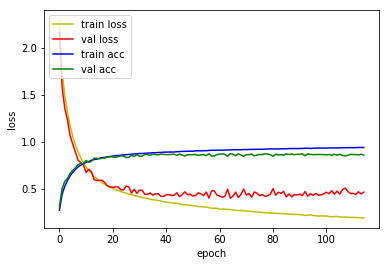

4815/4815 [==============================] - 2s 347us/sample - loss: 0.4886 - acc: 0.8546
Loss: 0.48855698931563807 Accuracy: 0.854621

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.1756 - acc: 0.3158
Epoch 00001: val_loss improved from inf to 1.90552, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_5_conv_checkpoint/001-1.9055.hdf5
36805/36805 [==============================] - 35s 939us/sample - loss: 2.1746 - acc: 0.3161 - val_loss: 1.9055 - val_acc: 0.3853
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.4206 - acc: 0.5595
Epoch 00002: val_loss improved from 1.90552 to 1.18108, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_5_conv_checkpoint/002-1.1811.hdf5
36805/36805 [==============================] - 29s 797us/sample - loss: 1.4210 - acc: 0.5595 - val_loss: 1.1811 - val_acc: 0.6508
Epoch 3/500
36800/36805 [==========================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2179 - acc: 0.9377
Epoch 00023: val_loss did not improve from 0.26829
36805/36805 [==============================] - 29s 791us/sample - loss: 0.2180 - acc: 0.9376 - val_loss: 0.2771 - val_acc: 0.9182
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2115 - acc: 0.9386
Epoch 00024: val_loss improved from 0.26829 to 0.26484, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_5_conv_checkpoint/024-0.2648.hdf5
36805/36805 [==============================] - 29s 793us/sample - loss: 0.2116 - acc: 0.9385 - val_loss: 0.2648 - val_acc: 0.9213
Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2032 - acc: 0.9407
Epoch 00025: val_loss did not improve from 0.26484
36805/36805 [==============================] - 29s 794us/sample - loss: 0.2034 - acc: 0.9406 - val_loss: 0.2768 - val_acc: 0.9136
Epoch 26/500
36736/36805 [============================>.] -

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1088 - acc: 0.9684
Epoch 00050: val_loss improved from 0.23736 to 0.23683, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_5_conv_checkpoint/050-0.2368.hdf5
36805/36805 [==============================] - 29s 792us/sample - loss: 0.1090 - acc: 0.9683 - val_loss: 0.2368 - val_acc: 0.9287
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1037 - acc: 0.9701
Epoch 00051: val_loss did not improve from 0.23683
36805/36805 [==============================] - 29s 790us/sample - loss: 0.1037 - acc: 0.9701 - val_loss: 0.2423 - val_acc: 0.9292
Epoch 52/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0989 - acc: 0.9724
Epoch 00052: val_loss did not improve from 0.23683
36805/36805 [==============================] - 29s 792us/sample - loss: 0.0991 - acc: 0.9723 - val_loss: 0.2469 - val_acc: 0.9262
Epoch 53/500
36736/36805 [============================>.] -

36736/36805 [============================>.] - ETA: 0s - loss: 0.0539 - acc: 0.9863
Epoch 00079: val_loss did not improve from 0.23683
36805/36805 [==============================] - 29s 791us/sample - loss: 0.0540 - acc: 0.9863 - val_loss: 0.2706 - val_acc: 0.9257
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0572 - acc: 0.9845
Epoch 00080: val_loss did not improve from 0.23683
36805/36805 [==============================] - 29s 792us/sample - loss: 0.0573 - acc: 0.9844 - val_loss: 0.2782 - val_acc: 0.9220
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0539 - acc: 0.9861
Epoch 00081: val_loss did not improve from 0.23683
36805/36805 [==============================] - 29s 792us/sample - loss: 0.0540 - acc: 0.9861 - val_loss: 0.2770 - val_acc: 0.9264
Epoch 82/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0505 - acc: 0.9877
Epoch 00082: val_loss did not improve from 0.23683
36805/36805 [==================

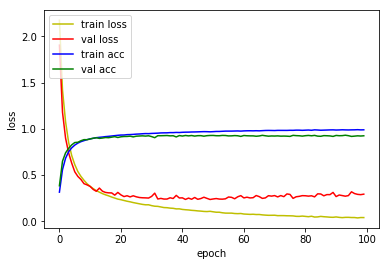

4815/4815 [==============================] - 2s 388us/sample - loss: 0.2979 - acc: 0.9099
Loss: 0.2979069372760915 Accuracy: 0.909865

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8505 - acc: 0.4247
Epoch 00001: val_loss improved from inf to 1.61732, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_6_conv_checkpoint/001-1.6173.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 1.8504 - acc: 0.4248 - val_loss: 1.6173 - val_acc: 0.4782
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9590 - acc: 0.7243
Epoch 00002: val_loss improved from 1.61732 to 0.73319, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_6_conv_checkpoint/002-0.7332.hdf5
36805/36805 [==============================] - 30s 826us/sample - loss: 0.9589 - acc: 0.7244 - val_loss: 0.7332 - val_acc: 0.7950
Epoch 3/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.1148 - acc: 0.9689
Epoch 00024: val_loss improved from 0.20158 to 0.20023, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_6_conv_checkpoint/024-0.2002.hdf5
36805/36805 [==============================] - 30s 822us/sample - loss: 0.1148 - acc: 0.9689 - val_loss: 0.2002 - val_acc: 0.9383
Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1110 - acc: 0.9690
Epoch 00025: val_loss did not improve from 0.20023
36805/36805 [==============================] - 30s 822us/sample - loss: 0.1110 - acc: 0.9690 - val_loss: 0.2114 - val_acc: 0.9334
Epoch 26/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1048 - acc: 0.9714
Epoch 00026: val_loss improved from 0.20023 to 0.19807, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_6_conv_checkpoint/026-0.1981.hdf5
36805/36805 [==============================] - 30s 821us/sample - loss: 0.1050 - acc: 0.9713 - 

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.9945
Epoch 00052: val_loss did not improve from 0.18583
36805/36805 [==============================] - 30s 822us/sample - loss: 0.0306 - acc: 0.9945 - val_loss: 0.2142 - val_acc: 0.9364
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9937
Epoch 00053: val_loss did not improve from 0.18583
36805/36805 [==============================] - 30s 825us/sample - loss: 0.0314 - acc: 0.9938 - val_loss: 0.2132 - val_acc: 0.9392
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9951
Epoch 00054: val_loss did not improve from 0.18583
36805/36805 [==============================] - 30s 822us/sample - loss: 0.0280 - acc: 0.9951 - val_loss: 0.2082 - val_acc: 0.9415
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0274 - acc: 0.9951
Epoch 00055: val_loss did not improve from 0.18583
36805/36805 [=====

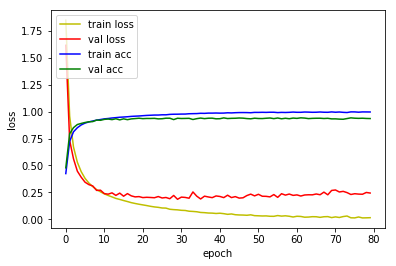

4815/4815 [==============================] - 2s 424us/sample - loss: 0.2293 - acc: 0.9306
Loss: 0.22926596655033582 Accuracy: 0.9306334

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6214 - acc: 0.5101
Epoch 00001: val_loss improved from inf to 1.46189, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_7_conv_checkpoint/001-1.4619.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.6214 - acc: 0.5101 - val_loss: 1.4619 - val_acc: 0.5355
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7361 - acc: 0.7904
Epoch 00002: val_loss improved from 1.46189 to 0.54550, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_7_conv_checkpoint/002-0.5455.hdf5
36805/36805 [==============================] - 31s 853us/sample - loss: 0.7360 - acc: 0.7904 - val_loss: 0.5455 - val_acc: 0.8544
Epoch 3/500
36800/36805 [===========================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0611 - acc: 0.9856
Epoch 00025: val_loss did not improve from 0.16592
36805/36805 [==============================] - 31s 854us/sample - loss: 0.0611 - acc: 0.9856 - val_loss: 0.1710 - val_acc: 0.9488
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0580 - acc: 0.9856
Epoch 00026: val_loss did not improve from 0.16592
36805/36805 [==============================] - 32s 856us/sample - loss: 0.0580 - acc: 0.9856 - val_loss: 0.1942 - val_acc: 0.9415
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0584 - acc: 0.9857
Epoch 00027: val_loss did not improve from 0.16592
36805/36805 [==============================] - 31s 850us/sample - loss: 0.0584 - acc: 0.9857 - val_loss: 0.1756 - val_acc: 0.9448
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0497 - acc: 0.9892
Epoch 00028: val_loss did not improve from 0.16592
36805/36805 [=====

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0128 - acc: 0.9981
Epoch 00055: val_loss did not improve from 0.16592
36805/36805 [==============================] - 31s 838us/sample - loss: 0.0128 - acc: 0.9981 - val_loss: 0.2099 - val_acc: 0.9455
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9956
Epoch 00056: val_loss did not improve from 0.16592
36805/36805 [==============================] - 31s 849us/sample - loss: 0.0192 - acc: 0.9956 - val_loss: 0.2007 - val_acc: 0.9469
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9944
Epoch 00057: val_loss did not improve from 0.16592
36805/36805 [==============================] - 31s 845us/sample - loss: 0.0219 - acc: 0.9944 - val_loss: 0.1852 - val_acc: 0.9485
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9984
Epoch 00058: val_loss did not improve from 0.16592
36805/36805 [=====

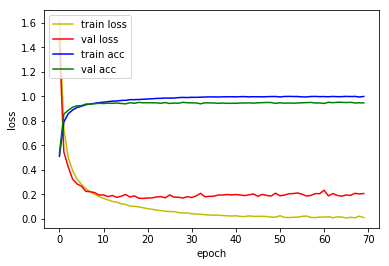

4815/4815 [==============================] - 2s 456us/sample - loss: 0.1987 - acc: 0.9364
Loss: 0.19870965909116117 Accuracy: 0.9364486

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5697 - acc: 0.5165
Epoch 00001: val_loss improved from inf to 1.23433, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_8_conv_checkpoint/001-1.2343.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 1.5698 - acc: 0.5164 - val_loss: 1.2343 - val_acc: 0.6334
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7139 - acc: 0.7865
Epoch 00002: val_loss improved from 1.23433 to 0.52511, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_32_BN_8_conv_checkpoint/002-0.5251.hdf5
36805/36805 [==============================] - 32s 879us/sample - loss: 0.7140 - acc: 0.7865 - val_loss: 0.5251 - val_acc: 0.8442
Epoch 3/500
36800/36805 [===========================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9898
Epoch 00025: val_loss did not improve from 0.16600
36805/36805 [==============================] - 32s 876us/sample - loss: 0.0455 - acc: 0.9898 - val_loss: 0.1928 - val_acc: 0.9415
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0422 - acc: 0.9910
Epoch 00026: val_loss did not improve from 0.16600
36805/36805 [==============================] - 32s 876us/sample - loss: 0.0423 - acc: 0.9910 - val_loss: 0.1859 - val_acc: 0.9485
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0407 - acc: 0.9905
Epoch 00027: val_loss did not improve from 0.16600
36805/36805 [==============================] - 32s 874us/sample - loss: 0.0407 - acc: 0.9905 - val_loss: 0.1818 - val_acc: 0.9485
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0355 - acc: 0.9929
Epoch 00028: val_loss did not improve from 0.16600
36805/36805 [=====

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0140 - acc: 0.9967
Epoch 00055: val_loss did not improve from 0.16600
36805/36805 [==============================] - 32s 873us/sample - loss: 0.0142 - acc: 0.9966 - val_loss: 0.1881 - val_acc: 0.9567
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0188 - acc: 0.9950
Epoch 00056: val_loss did not improve from 0.16600
36805/36805 [==============================] - 32s 875us/sample - loss: 0.0189 - acc: 0.9950 - val_loss: 0.2119 - val_acc: 0.9476
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0143 - acc: 0.9965
Epoch 00057: val_loss did not improve from 0.16600
36805/36805 [==============================] - 32s 873us/sample - loss: 0.0143 - acc: 0.9965 - val_loss: 0.1898 - val_acc: 0.9532
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0066 - acc: 0.9992
Epoch 00058: val_loss did not improve from 0.16600
36805/36805 [=====

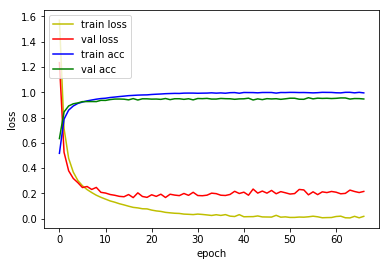

4815/4815 [==============================] - 2s 506us/sample - loss: 0.2115 - acc: 0.9344
Loss: 0.21154268181583963 Accuracy: 0.93437177



In [10]:
base = '1D_CNN_custom_multi_2_GMP_ch_32_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GMP_ch_32_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GMP_ch_32_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_39[0][0]  
____________________________________________________________

4815/4815 [==============================] - 2s 486us/sample - loss: 0.4886 - acc: 0.8546
Loss: 0.48855698931563807 Accuracy: 0.854621

1D_CNN_custom_multi_2_GMP_ch_32_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activatio

4815/4815 [==============================] - 3s 551us/sample - loss: 0.2293 - acc: 0.9306
Loss: 0.22926596655033582 Accuracy: 0.9306334

1D_CNN_custom_multi_2_GMP_ch_32_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activati

4815/4815 [==============================] - 3s 584us/sample - loss: 0.2115 - acc: 0.9344
Loss: 0.21154268181583963 Accuracy: 0.93437177


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_GMP_ch_32_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_39[0][0]  
____________________________________________________________

4815/4815 [==============================] - 3s 579us/sample - loss: 0.5606 - acc: 0.8428
Loss: 0.5605787344315589 Accuracy: 0.842783

1D_CNN_custom_multi_2_GMP_ch_32_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation

4815/4815 [==============================] - 3s 671us/sample - loss: 0.2951 - acc: 0.9254
Loss: 0.2950542231184176 Accuracy: 0.9254413

1D_CNN_custom_multi_2_GMP_ch_32_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activatio

4815/4815 [==============================] - 3s 689us/sample - loss: 0.2675 - acc: 0.9379
Loss: 0.2674754717670621 Accuracy: 0.9379024
